# Mushroom Clasification

In [12]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchmetrics
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models import ResNet18_Weights
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger


# Register matplotlib converters
pd.plotting.register_matplotlib_converters()

# IPython magic commands (for Jupyter notebooks)
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing custom help tool
from help_tool import help_tool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Train/Validate/Test data has been prepared in EDA step, with the partition of 70/15/16. These datasets were stratified, and contain class distribution.

In [3]:
train_dir = 'Archive/Split/Train'
validate_dir = 'Archive/Split/Validate'
test_dir = 'Archive/Split/Test'

In [4]:
classes = [entry.name for entry in Path(train_dir).iterdir() if entry.is_dir()]

The majority class is Lactarius, minority class is Hygrocybe.

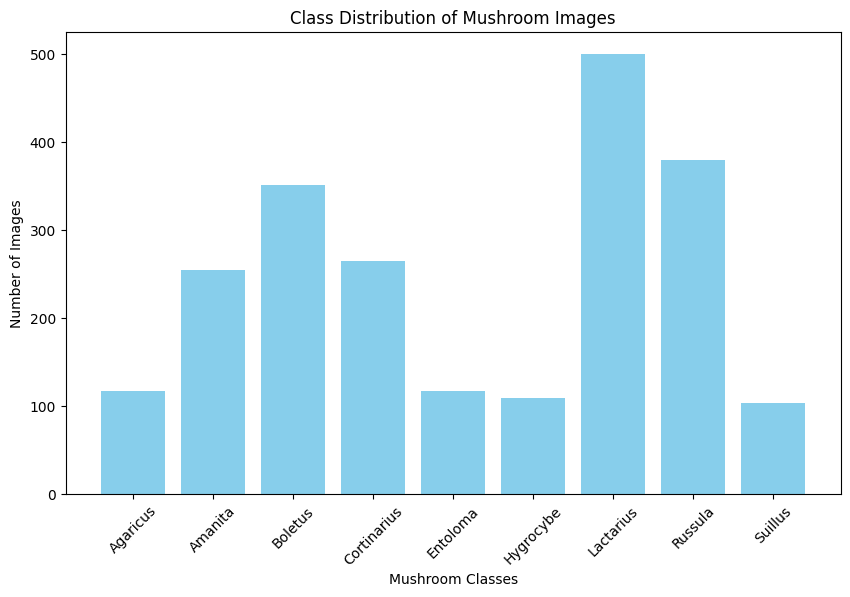

In [5]:
help_tool.plot_image_distribution(train_dir)

Each category is depicted in the plot, there's not just mushroom objects, but also leaves, dirt.

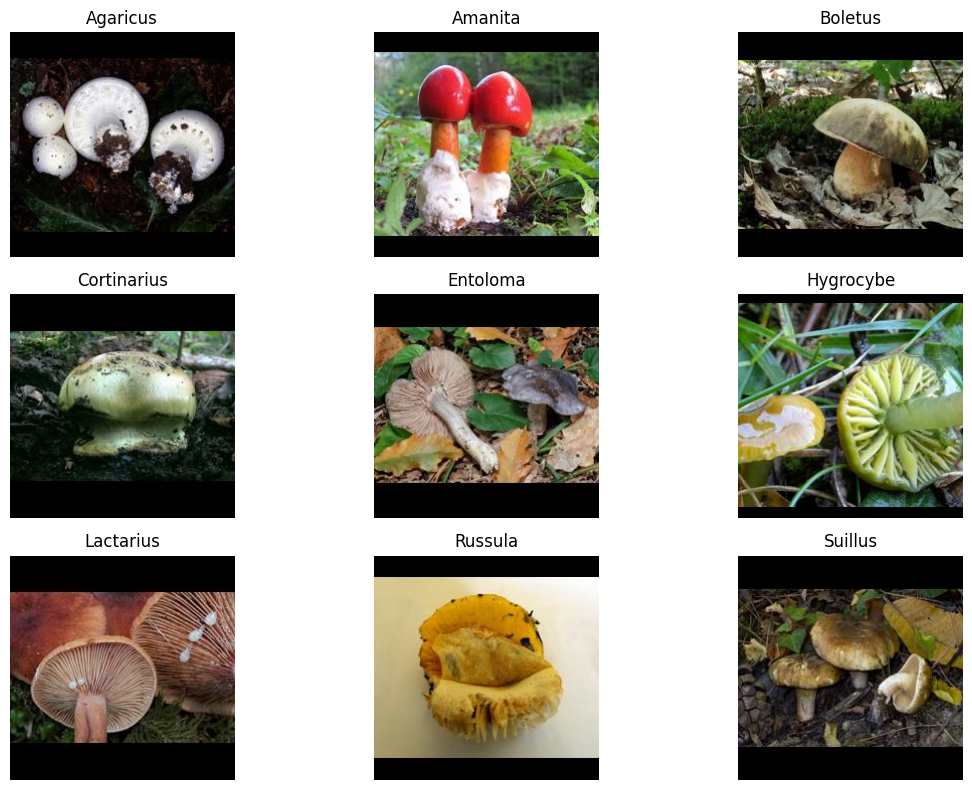

In [6]:
help_tool.visualize_sample_images(train_dir)

# Data Transformations

Data augmentation is done on RandomResizedCrop and RandomHorizontalFlip. Only 2 transformations were chossen, as adding more transformations was distorting the image so much that mushrooms were hard to distinguish for the human eye. The test model was also getting confused.

In [7]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [8]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(validate_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

Batch size is selected on the smaller scale - 16.

In [9]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          num_workers=8, shuffle=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        num_workers=8, shuffle=False, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
                         num_workers=8, shuffle=False, persistent_workers=True)

After augmentation, mushrooms look like mushrooms in both Train and Validations sets.

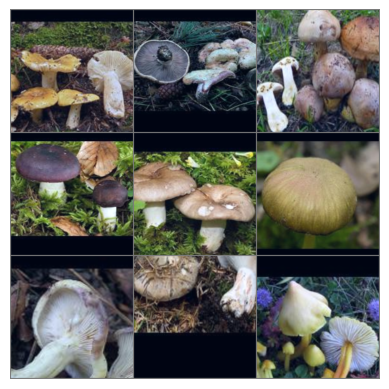

In [15]:
def sample_show(dataset):

    data_loader = DataLoader(dataset, batch_size=9, shuffle=True)

    # Get a batch of images
    data_iter = iter(data_loader)
    images, _ = next(data_iter)

    img_grid = torchvision.utils.make_grid(images, nrow=3)

    img = img_grid * 0.229 + 0.485
    # Clamp values to the range [0, 1] for visualization
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


sample_show(train_dataset)

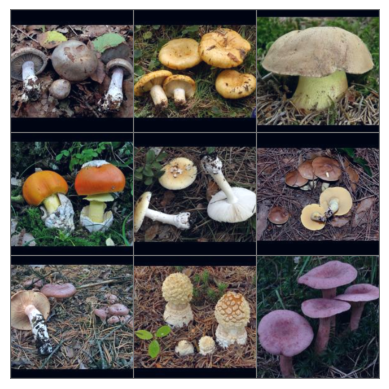

In [74]:
sample_show(val_dataset)

# Model development
## Transfer Learning with altered last layer
* Model is developed on ResNEt18 backbone
* Last layer is replaced and trained - data is not plentiful, and tuning all layers at once could lead to overfitting
* Optimizer is AdamW - Decouples weight decay from the gradient update, applying it directly to the weights after the gradient update. This optimization approach is expedted to improve model generalization

In [25]:
# Define the Lightning Module
class MyLightningModule(LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()

        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all the layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(
            task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(
            task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(
            task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(
            task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(
            task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(
            task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(
            task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(
            task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)

        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)

        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        # criterion = nn.CrossEntropyLoss()
        optimizer = AdamW(self.parameters(), lr=self.learning_rate,
                          weight_decay=self.weight_decay)
        scheduler = StepLR(
            optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [81]:
# Get the number of classes
classes = train_dataset.classes
num_classes = len(classes)


model = MyLightningModule(num_classes=num_classes, learning_rate=1e-3,
                          weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1)



checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    save_top_k=1,
    verbose=True,
    dirpath='checkpoints\AdamW',
    filename='mushroom-classifier-{epoch:02d}-{val_accuracy:.2f}'
)

tb_logger = TensorBoardLogger("tb_logs\AdamW", name="mushroom_classification")

trainer = Trainer(
    max_epochs=35,
    callbacks=[checkpoint_callback],
    log_every_n_steps=1,
    logger=tb_logger
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | ResNet              | 11.2 M | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_accuracy  | MulticlassAccuracy  | 0      | train
3 | train_precision | MulticlassPrecision | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | train_f1        | MulticlassF1Score   | 0      | train
6 | val_accuracy    | MulticlassAccuracy  | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
8 | val_recall      | MulticlassRecall    | 0      | train
9 | val_f1          | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 138: 'val_accuracy' reached 0.52427 (best 0.52427), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=00-val_accuracy=0.52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 276: 'val_accuracy' reached 0.60340 (best 0.60340), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=01-val_accuracy=0.60.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 414: 'val_accuracy' reached 0.64417 (best 0.64417), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=02-val_accuracy=0.64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 552: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 690: 'val_accuracy' reached 0.64709 (best 0.64709), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=04-val_accuracy=0.65.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 828: 'val_accuracy' reached 0.65340 (best 0.65340), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=05-val_accuracy=0.65.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 966: 'val_accuracy' reached 0.66553 (best 0.66553), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=06-val_accuracy=0.67.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1104: 'val_accuracy' reached 0.67913 (best 0.67913), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=07-val_accuracy=0.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1242: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1380: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1518: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1656: 'val_accuracy' reached 0.68641 (best 0.68641), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=11-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1794: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1932: 'val_accuracy' reached 0.68786 (best 0.68786), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=13-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2070: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 2208: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 2346: 'val_accuracy' reached 0.68835 (best 0.68835), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=16-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 2484: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 2622: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2760: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 2898: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 3036: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 3174: 'val_accuracy' reached 0.69223 (best 0.69223), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=22-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 3312: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 3450: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 3588: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 3726: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 3864: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 4002: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 4140: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 4278: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 4416: 'val_accuracy' reached 0.69320 (best 0.69320), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\AdamW\\mushroom-classifier-epoch=31-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 4554: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 4692: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 4830: 'val_accuracy' was not in top 1
`Trainer.fit` stopped: `max_epochs=35` reached.


Best performance is 69% Valuation Accuracy

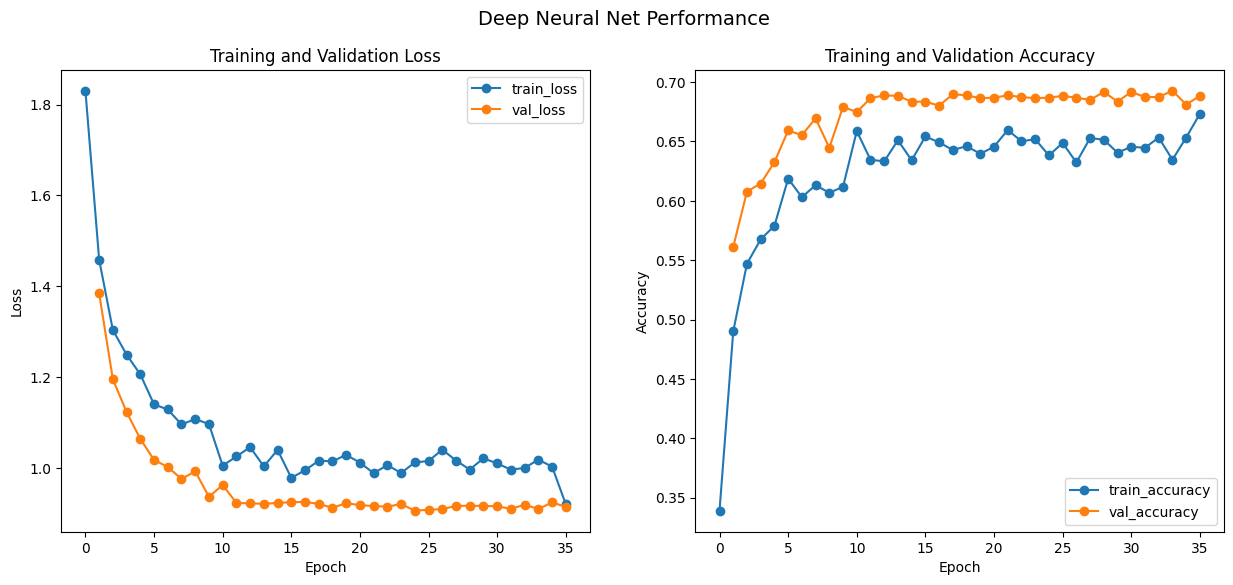

In [40]:
help_tool.loss_accuracy_plots(
    'tb_logs\mushroom_classification\\version_1\events.out.tfevents.1722431218.Sharaz-PC.15716.0', batch_size, train_loader)

Training and Validation Accuracy has 0.05 gap, but it's concidered not too large and acceptable. The model is not overfitted.

### Saving best run
Best model run is renamed to best_adamW_tuned_model

In [ ]:
save_number = 0

In [ ]:
if save_number == 1:
    best_model = MyLightningModule.load_from_checkpoint(
        "checkpoints\\mushroom-classifier-epoch=32-val_accuracy=0.69.ckpt")
    torch.save(best_model, 'transfer_learning_model.pth')
else:
    best_model = torch.load('transfer_learning_model.pth')

### Inference time of neural networks
Inference time in milliseconds on a GPU is 3.39 +/- 0.61 [ms]. 

Taken from <https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f>

In [46]:
help_tool.mean_inference_time(best_model)

Mean Inference = 3.39 [ms], Standard deviation = 0.61 [ms]


### Unseen dataset metrics
Unseen Test dataset shows 0.67% accuracy and similar values for the rest of metrics (Precision, Recall, F1).

In [45]:
help_tool.get_model_metrics(best_model, test_dataset, batch_size)

Accuracy: 0.6749
Precision: 0.6605
Recall: 0.6435
F1 Score: 0.6469


### Conclusion
* Transfer learning with ResNet18 has been retrained for Final Layer. The accieved accuracy is 67% and recall 64%.
* Inference mean time is 3.39 +/- 0.61 [ms].

## Fine Tuning
Keeping the same model set up, but updating the architecture for next to last layer (Layer 4) Fine Tuning. The last Linear layer is not altered.

In [28]:
class MyLightningModule_Tuning(LightningModule):

    """ 
    Transfer Learning Model.
    Besed on resnet18.
    Last Layer and Layer 4 modified.
    Optimizer AdamW. 
    """

    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule_Tuning, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()

        # Replacing Best Model
        self.model = best_model

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.model.layer4.parameters():
            param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(
            task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(
            task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(
            task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(
            task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(
            task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(
            task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(
            task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(
            task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)

        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)

        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        # criterion = nn.CrossEntropyLoss()
        optimizer = AdamW(self.parameters(), lr=self.learning_rate,
                          weight_decay=self.weight_decay)
        scheduler = StepLR(
            optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [29]:
model = MyLightningModule_Tuning(num_classes=num_classes, learning_rate=1e-1,
                                 weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1)

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    save_top_k=1,
    verbose=True,
    dirpath='checkpoints\Tuned_AdamW',
    filename='mushroom-classifier-{epoch:02d}-{val_accuracy:.2f}'
)

# Define TensorBoard logger
tb_logger = TensorBoardLogger(
    "tb_logs\Tuned_AdamW", name="mushroom_classification")

trainer = Trainer(
    max_epochs=35,
    callbacks=[checkpoint_callback],
    log_every_n_steps=1,
    logger=tb_logger
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\model_env\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\User\Desktop\Gintares_Projektai\Mushrooms_classification\checkpoints\Tuned_AdamW exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | MyLightningModule   | 11.2 M | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_accuracy  | MulticlassAccuracy  | 0      | train
3 | train_precision | MulticlassPrecision | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | train_f1        | MulticlassF1Score   | 0      | train
6 | val_accuracy    | MulticlassAccuracy  | 0      | train
7 | val_precision   |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 138: 'val_accuracy' reached 0.43495 (best 0.43495), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=00-val_accuracy=0.43.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 276: 'val_accuracy' reached 0.48252 (best 0.48252), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=01-val_accuracy=0.48.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 414: 'val_accuracy' reached 0.60728 (best 0.60728), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=02-val_accuracy=0.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 552: 'val_accuracy' reached 0.61748 (best 0.61748), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=03-val_accuracy=0.62.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 690: 'val_accuracy' reached 0.63738 (best 0.63738), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=04-val_accuracy=0.64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 828: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 966: 'val_accuracy' reached 0.65485 (best 0.65485), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=06-val_accuracy=0.65.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1104: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1242: 'val_accuracy' reached 0.69369 (best 0.69369), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=08-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1380: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1518: 'val_accuracy' reached 0.75243 (best 0.75243), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=10-val_accuracy=0.75.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1656: 'val_accuracy' reached 0.76893 (best 0.76893), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=11-val_accuracy=0.77.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1794: 'val_accuracy' reached 0.77524 (best 0.77524), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=12-val_accuracy=0.78.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1932: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2070: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 2208: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 2346: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 2484: 'val_accuracy' reached 0.77621 (best 0.77621), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=17-val_accuracy=0.78.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 2622: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2760: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 2898: 'val_accuracy' reached 0.78835 (best 0.78835), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=20-val_accuracy=0.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 3036: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 3174: 'val_accuracy' reached 0.79029 (best 0.79029), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=22-val_accuracy=0.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 3312: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 3450: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 3588: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 3726: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 3864: 'val_accuracy' reached 0.79709 (best 0.79709), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=27-val_accuracy=0.80.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 4002: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 4140: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 4278: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 4416: 'val_accuracy' reached 0.80049 (best 0.80049), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_AdamW\\mushroom-classifier-epoch=31-val_accuracy=0.80.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 4554: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 4692: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 4830: 'val_accuracy' was not in top 1
`Trainer.fit` stopped: `max_epochs=35` reached.


Best performance is 69% Accuracy.

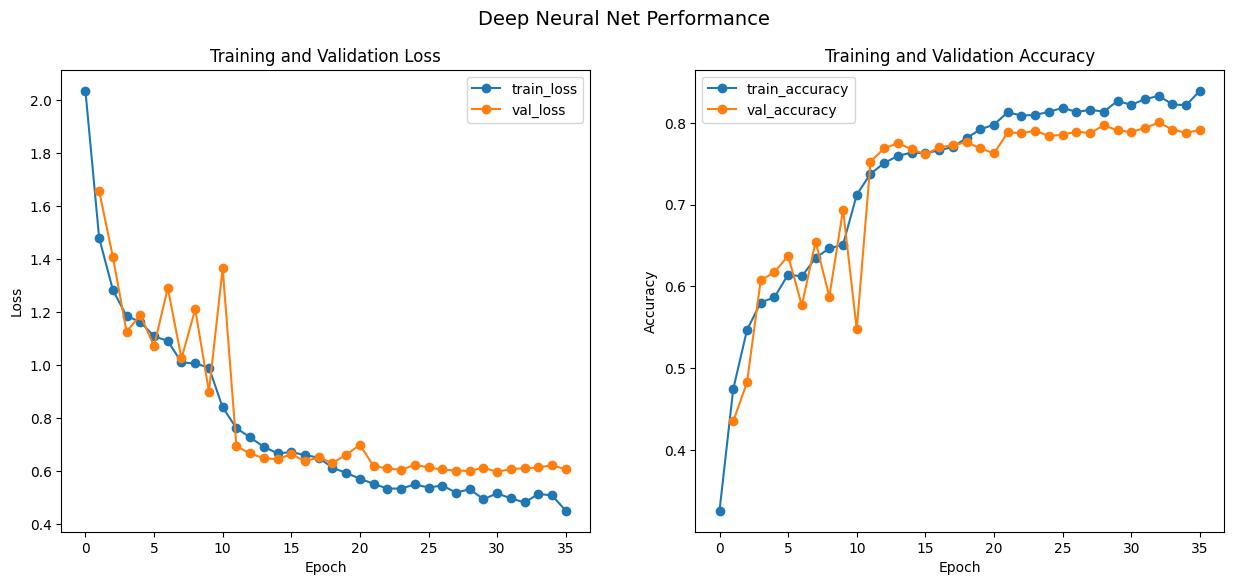

In [48]:
help_tool.loss_accuracy_plots(
    'tb_logs\Tuned_AdamW\mushroom_classification\\version_9\events.out.tfevents.1722493396.Sharaz-PC.17060.0', batch_size, train_loader)

Training and Validation have even more similar Accuracy and Loss numbers.

### Saving best run
Best model run is renamed to best_adamW_tuned_model

In [58]:
save_number = 0

In [59]:
if save_number == 1:
    best_adamW_tuned_model = MyLightningModule_Tuning.load_from_checkpoint(
        "checkpoints\Tuned_AdamW\\mushroom-classifier-epoch=31-val_accuracy=0.80.ckpt")
    torch.save(best_adamW_tuned_model, 'best_adamW_tuned_model.pth')
else:
    best_adamW_tuned_model = torch.load('best_adamW_tuned_model.pth')

### Inference time of neural networks
Tuned model takes 3.24 +/- 0.19 [ms], while untuned model took 3.39 +/- 0.61 [ms]. Overall, tuned model has a time decrease, but the time ranges overlap, so the decrease time is not significant.

In [61]:
help_tool.mean_inference_time(best_adamW_tuned_model)

Mean Inference = 3.24 [ms], Standard deviation = 0.19 [ms]


### Unseen dataset metrics
Unseen Test dataset shows 79% accuracy. Other metrics like Recall also show similar values. 

Model without Fine Tuning had 67% accuracy, which is 12% unbcrease after tuning.

In [60]:
help_tool.get_model_metrics(best_adamW_tuned_model, test_dataset, batch_size)

Accuracy: 0.7925
Precision: 0.7729
Recall: 0.7531
F1 Score: 0.7590


### Confusion Matrix
Confusion Matrix shows model is predicting mostly the classes that are expected, but classes with lower amount of training data (Entholoma) suffer from false negatives.

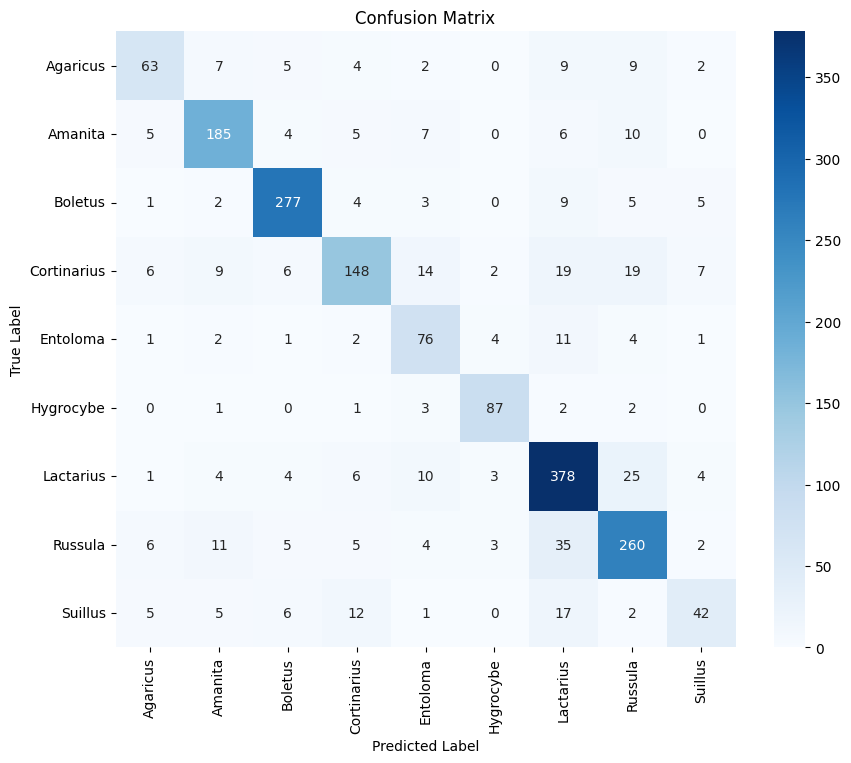

In [63]:
help_tool.confusion_matrix_plot(
    best_adamW_tuned_model, test_dataset, test_loader)

### Conclusion
* Transfer learning with ResNet18 has been retrained for Final Layer and Layer4 (second to last). The accieved accuracy is 79% and recall 75%. Model experienced 12% accuracy increase after fine tuning. 
* Inference mean time is 3.24 +/- 0.19 [ms].

<!-- checkpoint.keys() -->

## Change in Optimizer - SGD Optimizer
Stochastic Gradient Descent (SGD) with momentum. Adding momentum helps accelerate gradients vectors in the right directions, thus leading to faster converging.

In [68]:
# Define the Lightning Module
class MyLightningModule_SGD(LightningModule):
    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule_SGD, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()

        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze all the layers
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(
            task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(
            task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(
            task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(
            task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(
            task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(
            task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(
            task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(
            task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)

        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)

        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        optimizer = SGD(self.parameters(), lr=self.learning_rate,
                        momentum=0.9, weight_decay=self.weight_decay)
        scheduler = StepLR(
            optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [72]:
model = MyLightningModule_SGD(num_classes=num_classes, learning_rate=1e-3,
                              weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1)


# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    save_top_k=1,
    verbose=True,
    dirpath='checkpoints\SGD',
    filename='mushroom-classifier-{epoch:02d}-{val_accuracy:.2f}'
)

# Define TensorBoard logger
tb_logger = TensorBoardLogger("tb_logs\SGD", name="mushroom_classification")

trainer = Trainer(
    max_epochs=35,
    callbacks=[checkpoint_callback],
    log_every_n_steps=1,
    logger=tb_logger
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params | Mode 
----------------------------------------------------------------
0 | model           | ResNet              | 11.2 M | train
1 | criterion       | CrossEntropyLoss    | 0      | train
2 | train_accuracy  | MulticlassAccuracy  | 0      | train
3 | train_precision | MulticlassPrecision | 0      | train
4 | train_recall    | MulticlassRecall    | 0      | train
5 | train_f1        | MulticlassF1Score   | 0      | train
6 | val_accuracy    | MulticlassAccuracy  | 0      | train
7 | val_precision   | MulticlassPrecision | 0      | train
8 | val_recall      | MulticlassRecall    | 0      | train
9 | val_f1          | MulticlassF1Score   | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 138: 'val_accuracy' reached 0.56942 (best 0.56942), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\SGD\\mushroom-classifier-epoch=00-val_accuracy=0.57.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 276: 'val_accuracy' reached 0.61165 (best 0.61165), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\SGD\\mushroom-classifier-epoch=01-val_accuracy=0.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 414: 'val_accuracy' reached 0.62621 (best 0.62621), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\SGD\\mushroom-classifier-epoch=02-val_accuracy=0.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 552: 'val_accuracy' reached 0.62913 (best 0.62913), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\SGD\\mushroom-classifier-epoch=03-val_accuracy=0.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 690: 'val_accuracy' reached 0.65291 (best 0.65291), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\SGD\\mushroom-classifier-epoch=04-val_accuracy=0.65.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 828: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 966: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1104: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1242: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1380: 'val_accuracy' reached 0.66942 (best 0.66942), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\SGD\\mushroom-classifier-epoch=09-val_accuracy=0.67.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1518: 'val_accuracy' reached 0.68786 (best 0.68786), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\SGD\\mushroom-classifier-epoch=10-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1656: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1794: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1932: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2070: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 2208: 'val_accuracy' reached 0.69320 (best 0.69320), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\SGD\\mushroom-classifier-epoch=15-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 2346: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 2484: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 2622: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2760: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 2898: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 3036: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 3174: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 3312: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 3450: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 3588: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 3726: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 3864: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 4002: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 4140: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 4278: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 4416: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 4554: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 4692: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 4830: 'val_accuracy' was not in top 1
`Trainer.fit` stopped: `max_epochs=35` reached.


Best performance is 69% Accuracy.

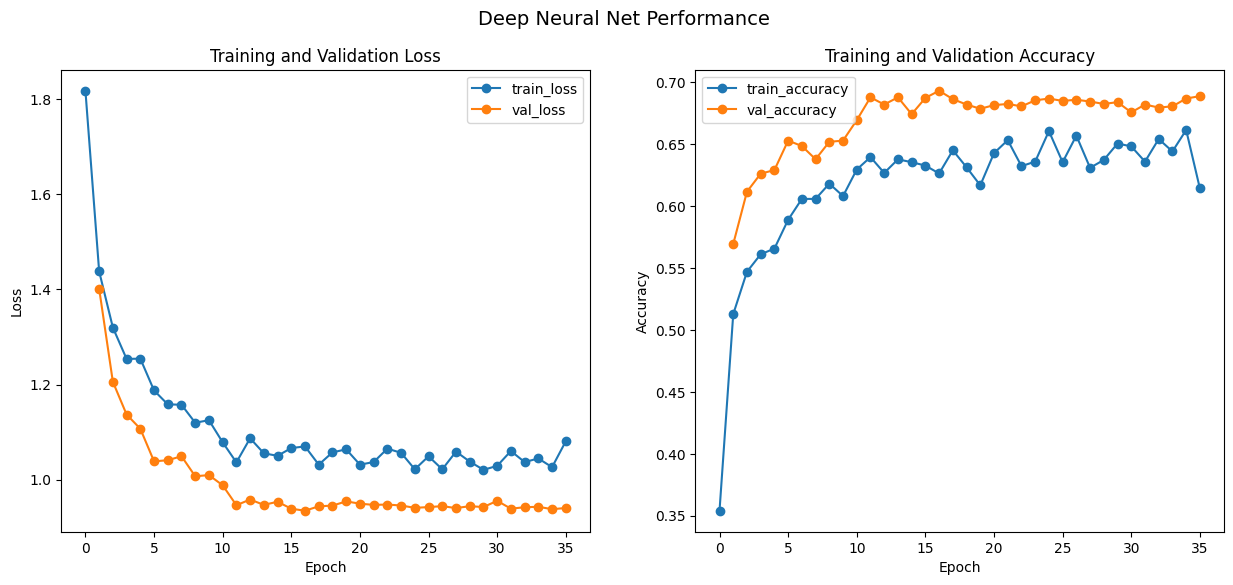

In [90]:
help_tool.loss_accuracy_plots(
    'tb_logs\SGD\mushroom_classification\\version_2\\events.out.tfevents.1722497661.Sharaz-PC.17060.3', batch_size, train_loader)

### Saving best run
Best model run is renamed to best_model_sgd

In [97]:
save_number = 0

In [85]:
if save_number == 1:
    best_model_sgd = MyLightningModule_SGD.load_from_checkpoint(
        "checkpoints\SGD\\mushroom-classifier-epoch=15-val_accuracy=0.69.ckpt")
    torch.save(best_model_sgd, 'transfer_learning_model_SGD.pth')
else:
    best_model_sgd = torch.load('transfer_learning_model_SGD.pth')

### Inference time of neural networks
Tuned model takes 3.23 +/- 0.20 [ms]. Which is similar run time as AdamW optimizer.

In [87]:
help_tool.mean_inference_time(best_model_sgd)

Mean Inference = 3.23 [ms], Standard deviation = 0.20 [ms]


### Unseen dataset metrics
Model with SGD Optimizer shows very similar metrics as AdamW optimizer.

In [86]:
help_tool.get_model_metrics(best_model_sgd, test_dataset, batch_size)

Accuracy: 0.6879
Precision: 0.6655
Recall: 0.6377
F1 Score: 0.6480


## Fine Tuning SGD Optimizer
Keeping the same model set up, but updating the architecture for next to last layer (Layer 4) Fine Tuning. The last Linear layer is not altered.

In [112]:
class MyLightningModule_Tuning_SGD(LightningModule):

    """ 
    Transfer Learning Model.
    Besed on resnet18.
    Last Layer and Layer 4 modified.
    Optimizer SGD. 
    """

    def __init__(self, num_classes, learning_rate=1e-3, weight_decay=1e-2, scheduler_step_size=10, scheduler_gamma=0.1):
        super(MyLightningModule_Tuning_SGD, self).__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.scheduler_step_size = scheduler_step_size
        self.scheduler_gamma = scheduler_gamma
        self.save_hyperparameters()

        # Replacing Best Model
        self.model = torch.load('transfer_learning_model_SGD.pth')

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.model.layer4.parameters():
            param.requires_grad = True

        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.train_accuracy = torchmetrics.Accuracy(
            task='multiclass', num_classes=num_classes)
        self.train_precision = torchmetrics.Precision(
            task='multiclass', num_classes=num_classes, average='macro')
        self.train_recall = torchmetrics.Recall(
            task='multiclass', num_classes=num_classes, average='macro')
        self.train_f1 = torchmetrics.F1Score(
            task='multiclass', num_classes=num_classes, average='macro')

        self.val_accuracy = torchmetrics.Accuracy(
            task='multiclass', num_classes=num_classes)
        self.val_precision = torchmetrics.Precision(
            task='multiclass', num_classes=num_classes, average='macro')
        self.val_recall = torchmetrics.Recall(
            task='multiclass', num_classes=num_classes, average='macro')
        self.val_f1 = torchmetrics.F1Score(
            task='multiclass', num_classes=num_classes, average='macro')

    def forward(self, x):
        """Defines the forward pass"""
        return self.model(x)

    def training_step(self, batch, batch_idx):
        """Computes the training loss and metrics"""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)

        # Log loss
        self.log('train_loss', loss)

        # Log metrics
        self.train_accuracy(y_hat, y)
        self.train_precision(y_hat, y)
        self.train_recall(y_hat, y)
        self.train_f1(y_hat, y)

        self.log('train_accuracy', self.train_accuracy, prog_bar=True)
        self.log('train_precision', self.train_precision, prog_bar=True)
        self.log('train_recall', self.train_recall, prog_bar=True)
        self.log('train_f1', self.train_f1, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """Computes the validation loss and metrics"""
        x, y = batch
        y_hat = self(x)
        val_loss = self.criterion(y_hat, y)

        # Log loss
        self.log('val_loss', val_loss, prog_bar=True)

        # Log metrics
        self.val_accuracy(y_hat, y)
        self.val_precision(y_hat, y)
        self.val_recall(y_hat, y)
        self.val_f1(y_hat, y)

        self.log('val_accuracy', self.val_accuracy, prog_bar=True)
        self.log('val_precision', self.val_precision, prog_bar=True)
        self.log('val_recall', self.val_recall, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

        return val_loss

    def configure_optimizers(self):
        """Configures the optimizer and scheduler"""
        optimizer = SGD(self.parameters(), lr=self.learning_rate,
                        momentum=0.9, weight_decay=self.weight_decay)
        scheduler = StepLR(
            optimizer, step_size=self.scheduler_step_size, gamma=self.scheduler_gamma)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [114]:
model = MyLightningModule_Tuning_SGD(num_classes=num_classes, learning_rate=1e-2, weight_decay=1e-1, scheduler_step_size=10, scheduler_gamma=0.1)


# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='val_accuracy',
    mode='max',
    save_top_k=1,
    verbose=True,
    dirpath='checkpoints\Tuned_SGD',
    filename='mushroom-classifier-{epoch:02d}-{val_accuracy:.2f}'
)

# Define TensorBoard logger
tb_logger = TensorBoardLogger("tb_logs\Tuned_SGD", name="mushroom_classification")

trainer = Trainer(
    max_epochs= 35, 
    callbacks=[checkpoint_callback], 
    log_every_n_steps=1,
    logger=tb_logger
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                  | Params | Mode 
------------------------------------------------------------------
0 | model           | MyLightningModule_SGD | 11.2 M | train
1 | criterion       | CrossEntropyLoss      | 0      | train
2 | train_accuracy  | MulticlassAccuracy    | 0      | train
3 | train_precision | MulticlassPrecision   | 0      | train
4 | train_recall    | MulticlassRecall      | 0      | train
5 | train_f1        | MulticlassF1Score     | 0      | train
6 | val_accuracy    | MulticlassAccuracy    | 0      | train
7 | val_precision   | MulticlassPrecision   | 0      | train
8 | val_recall      | MulticlassRecall      | 0      | train
9 | val_f1          | MulticlassF1Score     | 0      | train
------------------------------------------------------------------
8.4 M     Trainable params
2.8 M    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 138: 'val_accuracy' reached 0.52476 (best 0.52476), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=00-val_accuracy=0.52.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 276: 'val_accuracy' reached 0.52621 (best 0.52621), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=01-val_accuracy=0.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 414: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 552: 'val_accuracy' reached 0.53155 (best 0.53155), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=03-val_accuracy=0.53.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 690: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 828: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 966: 'val_accuracy' reached 0.56359 (best 0.56359), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=06-val_accuracy=0.56.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1104: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 1242: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 1380: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 1518: 'val_accuracy' reached 0.63252 (best 0.63252), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=10-val_accuracy=0.63.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 1656: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 1794: 'val_accuracy' reached 0.64272 (best 0.64272), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=12-val_accuracy=0.64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 1932: 'val_accuracy' reached 0.65534 (best 0.65534), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=13-val_accuracy=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 2070: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 2208: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 2346: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 2484: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 2622: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 2760: 'val_accuracy' reached 0.65971 (best 0.65971), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=19-val_accuracy=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 2898: 'val_accuracy' reached 0.68107 (best 0.68107), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=20-val_accuracy=0.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 3036: 'val_accuracy' reached 0.69272 (best 0.69272), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=21-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 3174: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 3312: 'val_accuracy' reached 0.69417 (best 0.69417), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=23-val_accuracy=0.69.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 3450: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 3588: 'val_accuracy' reached 0.71165 (best 0.71165), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=25-val_accuracy=0.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 3726: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 3864: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 4002: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 4140: 'val_accuracy' reached 0.71311 (best 0.71311), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=29-val_accuracy=0.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30, global step 4278: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31, global step 4416: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32, global step 4554: 'val_accuracy' reached 0.71408 (best 0.71408), saving model to 'C:\\Users\\User\\Desktop\\Gintares_Projektai\\Mushrooms_classification\\checkpoints\\Tuned_SGD\\mushroom-classifier-epoch=32-val_accuracy=0.71.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33, global step 4692: 'val_accuracy' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34, global step 4830: 'val_accuracy' was not in top 1
`Trainer.fit` stopped: `max_epochs=35` reached.


Best performance is 71% Accuracy.

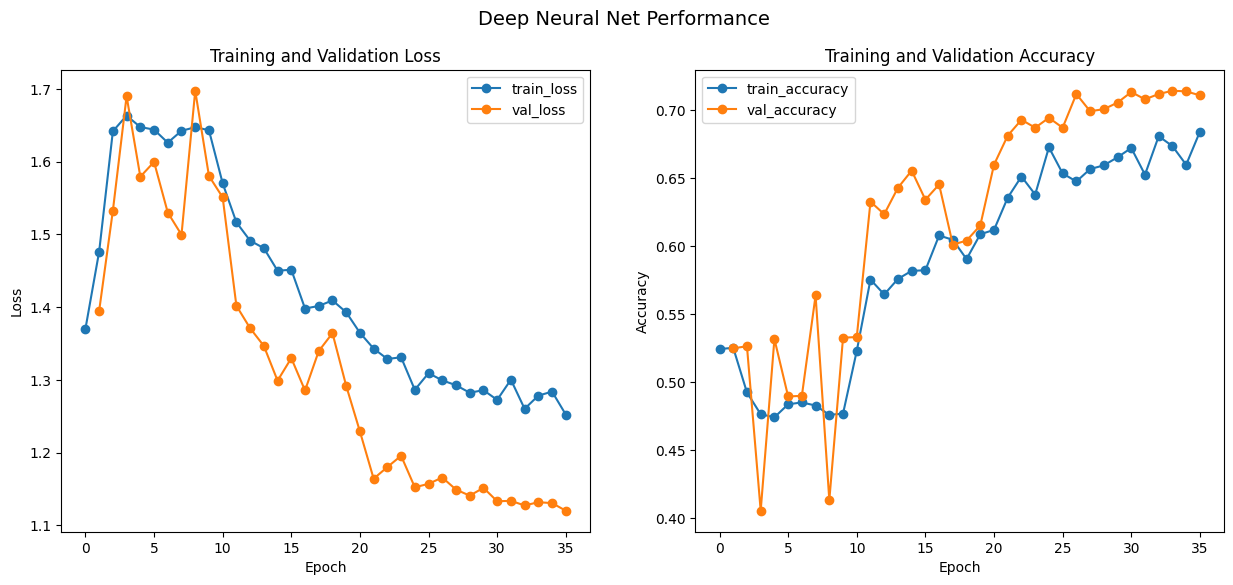

In [115]:
help_tool.loss_accuracy_plots(
    'tb_logs\Tuned_SGD\mushroom_classification\\version_7\\events.out.tfevents.1722500285.Sharaz-PC.17060.11', batch_size, train_loader)

Tuned SGD shows slight increase of validation accuracy, compared to tuned accuracy. This show model is underfitted. However, learning rate was adjusted and purposely chosen to be significantly higher than non tuned models, as to penalize Layer4 less for issues of Final Layer.
Thus, Underfitting could be attributed to optimizer SGD.

### Saving best run
Best model run is renamed to tuned_model_SGD

In [116]:
save_number = 0

In [137]:
if save_number == 1:
    tuned_model_SGD = MyLightningModule_Tuning_SGD.load_from_checkpoint(
        "checkpoints\Tuned_SGD\\mushroom-classifier-epoch=32-val_accuracy=0.71.ckpt")
    torch.save(tuned_model_SGD, 'tuned_model_SGD.pth')
else:
    tuned_model_SGD = torch.load('tuned_model_SGD.pth')

### Inference time of neural networks
Tuned model takes 4.03 +/- 0.81 [ms]. Which is much more time than untuned model 3.23 +/- 0.20 [ms].

In [139]:
help_tool.mean_inference_time(torch.load('tuned_model_SGD.pth'))

Mean Inference = 4.03 [ms], Standard deviation = 0.81 [ms]


### Unseen dataset metrics
Unseen data show model prefers to choose the majority class and has 58% F1 score. Which proves AdamW is more efficient at optimising.

In [140]:
help_tool.get_model_metrics(torch.load(
    'tuned_model_SGD.pth'), test_dataset, batch_size)

Accuracy: 0.7224
Precision: 0.7808
Recall: 0.5891
F1 Score: 0.5824


### Conclusion
* Trasnfer learning was done on ResNet18, with optimizer SGD. Last Layer was replaced for classificanion, and metric seamed similar to AdamW optimizer, but after Fine Tuning the SGD model became underfitted, even with increased Learning Rate. This could be attributed to Stochastic Gradient Descent (SGD) using a single learning rate for all parameters, which might not be ideal for all parameters.

# Conclusion
* Transfer learning model was created for ResNet18, AdamW optimization and Fine Tuning yielded 79% Accuracy and 75% Recall. Model experienced 12% accuracy increase after fine tuning. Inference mean time was 3.24 +/- 0.19 [ms]. `
* Stochastic Gradient Descent was tested for Optimizer, but model suffered underfitting after Fine Tuning, this could be due to usage of single learning rate for all parameters.